In [ ]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, Reshape, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import glob
import imageio
import re
import skimage
from skimage import measure
import skimage.measure as measure
import matplotlib.pyplot as plt
import argparse
import random
from platform import python_version
import keras
from tqdm import tqdm
from PIL import Image



Setting data path for data: both contour directory and original scan path. array of scans and contours - resized for use for further code - expand dimesions for last channel = colour

In [ ]:
all_scans=[]
all_lines=[]
#reading in all data - both ground truth masks and corresponding CTs
img_dir="/content/drive/MyDrive/Colab Notebooks/ADID-UNET/"
data_path_pictures=os.path.join(img_dir,'COVID_MEDSEG_20_patients_20_April_Pictures/*g')
files=glob.glob(data_path_pictures)



cont_dir="/content/drive/MyDrive/Colab Notebooks/ADID-UNET/COVID_MEDSEG_20_patients_20_April_Masks_0_1/"

mysize=128
dim = (mysize, mysize)
print(files)
for f1 in tqdm(files):
    readscan=np.asarray(cv2.resize((image.imread(f1)),dim,interpolation=cv2.INTER_AREA)) #reads file f1 as an image
    all_scans.append(readscan)#adds it to all the scans
    name_of_file=re.split('/',f1)[-1] #extracts just file name
    readlines=np.asarray(cv2.resize((image.imread(cont_dir+name_of_file)),dim,interpolation=cv2.INTER_AREA)) #reads in mask (assuming same file name as f1)
    all_lines.append(readlines) #adds this to masks.


#expand dims ensures that the last channel is the colour (1)
X=np.expand_dims(np.rollaxis(np.dstack(all_scans),-1),3)
Y=np.expand_dims(np.rollaxis(np.dstack(all_lines),-1),3)
#print(all_scans)

In [ ]:
#removing CT's and masks with no COVID-19 present from dataset
no_masks=[]
for i in range (0,len(all_lines)):
  if np.unique(all_lines[i]).size==1:
    no_masks.append(i)
print("number of complete black masks:",len(no_masks))

for index in sorted (no_masks, reverse=True):
  del all_lines[index]
  del all_scans[index]


In [ ]:
X=np.expand_dims(np.rollaxis(np.dstack(all_scans),-1),3)
Y=np.expand_dims(np.rollaxis(np.dstack(all_lines),-1),3)

Writing the autoencoder: input image with set shape, fed through 3 convolutional layers and encoded layer with maxpooling function and activation ReLU. Decoder includes 3 transposed convolutional layers (ReLU) with a decoded layer (activation sigmoid) - all padding = same
optimizer- adam, loss - binary_crossentropy

In [ ]:
len(X)
new_X=[]
new_Y=[]
randnums= np.random.randint(1,1844,1844)

for i in randnums:
  new_X.append(X[i])
  new_Y.append(Y[i])

newer_X=np.array(new_X)
newer_Y=np.array(new_Y)

In [ ]:
input_img=Input(shape=(X[0].shape))
#encoded layers
x = Conv2D(64,(3,3),activation='relu',padding='same')(input_img)

x = Conv2D(32,(3,3),activation='relu',padding='same')(x)

x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2),padding='same')(x)

    #decoded layers
x = Conv2DTranspose(16,(3,3), strides=2, activation='relu',padding='same')(encoded)

x = Conv2DTranspose(32,(3,3), activation='relu',padding='same')(x)

x = Conv2DTranspose(64,(3,3), activation='relu',padding='same')(x)

decoded = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(x)

#defining model, compliling and summary
autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 16)     2320      
 ranspose)                                                 

Setting test and train data split with 80/20 split

In [ ]:
#randomly split data 80/20
x_train, x_test = train_test_split(newer_X, test_size=0.2, random_state=16)
y_train, y_test = train_test_split(newer_Y, test_size=0.2, random_state=16)

In [ ]:
#augmenting training dataset
x_aug=[]
y_aug=[]
for i in range(len(x_train)):
  x_aug.append((x_train[i].reshape(mysize,mysize)))
  y_aug.append((y_train[i].reshape(mysize,mysize)))
  x_aug.append(np.flipud(x_train[i]).reshape(mysize,mysize))
  y_aug.append(np.flipud(y_train[i].reshape(mysize,mysize)))
  x_aug.append(np.fliplr(x_train[i].reshape(mysize,mysize)))
  y_aug.append(np.fliplr(y_train[i].reshape(mysize,mysize)))
  x_aug.append(np.flipud(np.fliplr(x_train[i].reshape(mysize,mysize))))
  y_aug.append(np.flipud(np.fliplr(y_train[i].reshape(mysize,mysize))))


In [ ]:
#redefine x and y for training model
new_X_aug=np.array(x_aug)
new_Y_aug=np.array(y_aug)
X_2=np.expand_dims(np.rollaxis(np.dstack(new_X_aug),-1),3)
Y_2=np.expand_dims(np.rollaxis(np.dstack(new_Y_aug),-1),3)



In [ ]:
#training model
history = autoencoder.fit(X_2, Y_2,
                          batch_size=2,
                          epochs=60,
                          shuffle=True,
                          verbose=1,
                          validation_data=(x_test, y_test))




Epoch 1/60
2950/2950 [==============================] - 32s 7ms/step - loss: 0.0573 - val_loss: 0.0319
Epoch 2/60
2950/2950 [==============================] - 19s 7ms/step - loss: 0.0294 - val_loss: 0.0241
Epoch 3/60
2950/2950 [==============================] - 19s 6ms/step - loss: 0.0244 - val_loss: 0.0214
Epoch 4/60
2950/2950 [==============================] - 19s 7ms/step - loss: 0.0225 - val_loss: 0.0202
Epoch 5/60
2950/2950 [==============================] - 19s 7ms/step - loss: 0.0214 - val_loss: 0.0191
Epoch 6/60
2950/2950 [==============================] - 19s 7ms/step - loss: 0.0202 - val_loss: 0.0218
Epoch 7/60
2950/2950 [==============================] - 20s 7ms/step - loss: 0.0194 - val_loss: 0.0207
Epoch 8/60
2950/2950 [==============================] - 19s 7ms/step - loss: 0.0186 - val_loss: 0.0174
Epoch 9/60
2950/2950 [==============================] - 20s 7ms/step - loss: 0.0182 - val_loss: 0.0167
Epoch 10/60
2950/2950 [==============================] - 19s 7ms/step - l

Give predition of test (output of autoencoder from seeing unseen images) - displaying contour, original image and predicted contour.

12/12 [==============================] - 3s 107ms/step


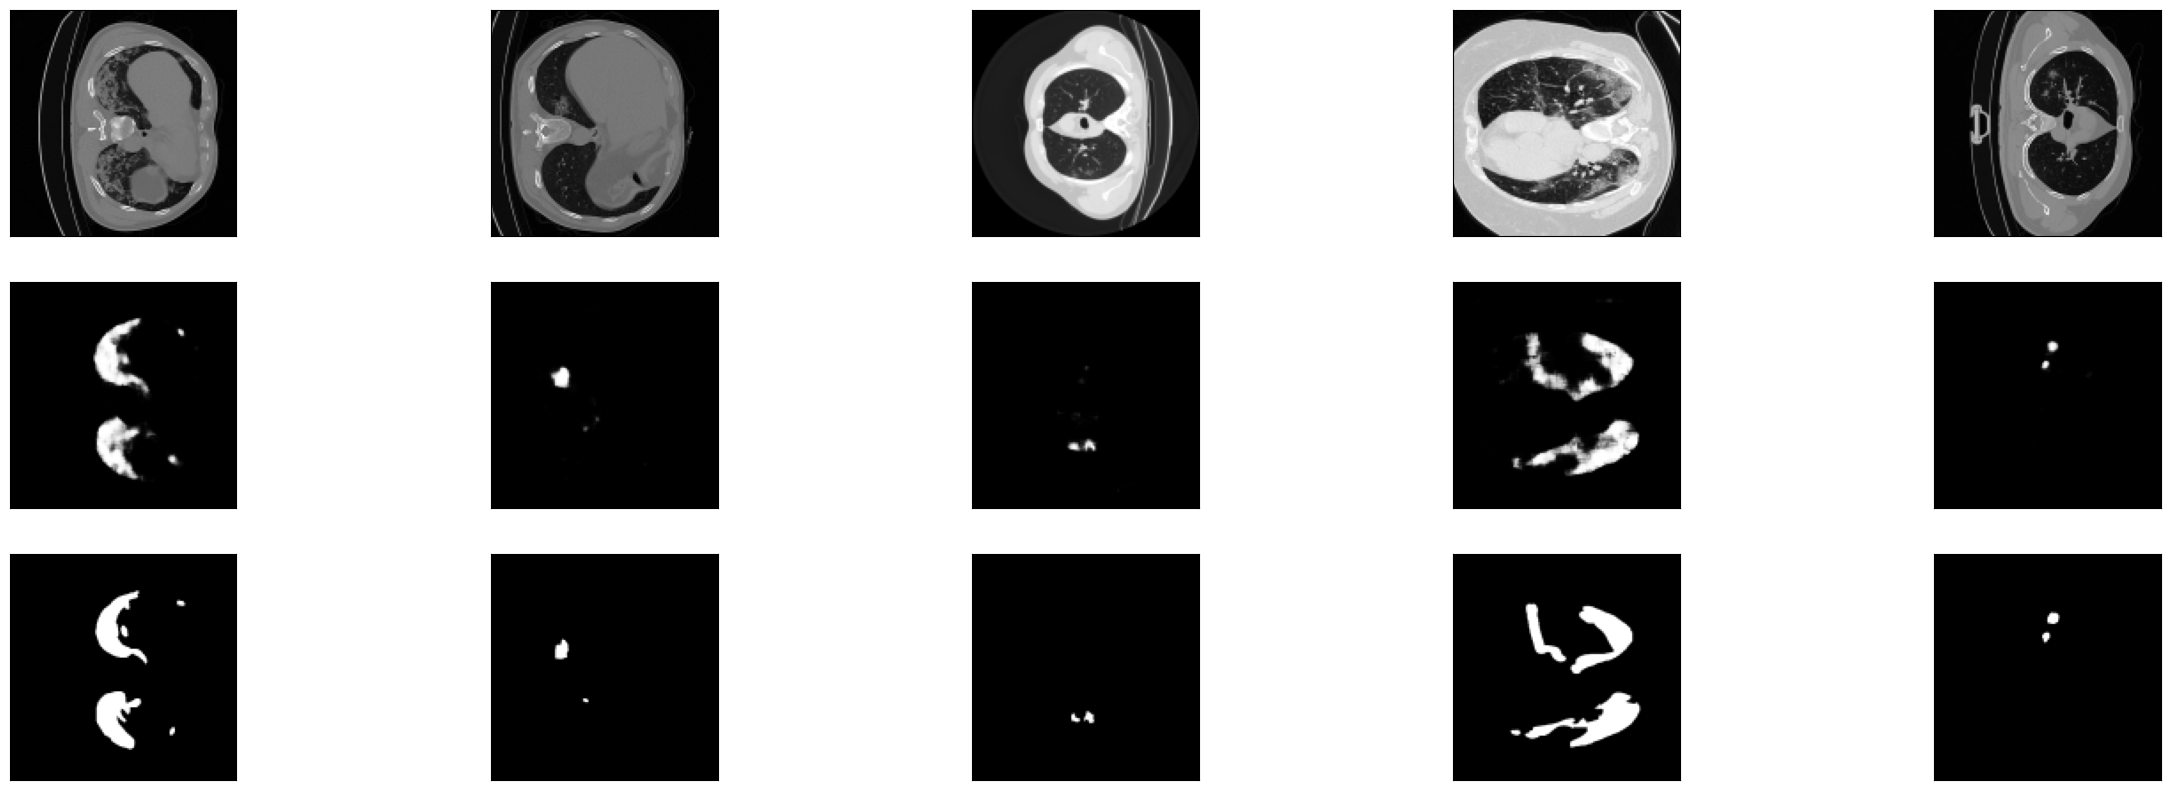

In [ ]:
decoded_img = autoencoder.predict(x_test)

n=5
plt.figure(figsize=(30,10))
for i in range (1,n+1):

    #display original (CT)
    ax= plt.subplot(3,n,i)
    plt.imshow(x_test[i].reshape(mysize,mysize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #display prediction
    ax1=plt.subplot(3,n,i+n)
    plt.imshow(decoded_img[i].reshape(mysize,mysize))
    plt.gray()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    #display contour (GT)
    ax2=plt.subplot(3,n,i+2*n)
    plt.imshow(y_test[i].reshape(mysize,mysize))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)


plt.show()






Produce graph to show training loss for test and training data as number of epochs increase...

In [ ]:
#code to save prediction images as png file
for i in range (len(decoded_img)):
    Prediction=(decoded_img[i].reshape(mysize,mysize))
    predict_name = "/content/drive/MyDrive/Colab Notebooks/ADID-UNET/PredictionResults2022/64_32_16_5900/Test_Image_"+str(i+1)+"_Predict.png"
    plt.imsave(predict_name,Prediction)
#saves prediction from the test images

In [ ]:
#code to save Ground truth (original mask) as png
for i in range (len(decoded_img)):
    GroundTruth=(y_test[i].reshape(mysize,mysize))
    GT = "/content/drive/MyDrive/Colab Notebooks/ADID-UNET/GT/64_32_16_5900/Test_Image_"+str(i+1)+"_OriginalMask.png"
    plt.imsave(GT,GroundTruth)

#saves GT of test images

In [ ]:
 #code to save CT scan as png
for i in range (len(decoded_img)):
    CTscan=(x_test[i].reshape(mysize,mysize))
    CT = "/content/drive/MyDrive/Colab Notebooks/ADID-UNET/CT/64_32_16_Epoch50/Test_Image_"+str(i+1)+".png"
    plt.imsave(CT,CTscan)
#saves CT of test images